In [2]:
# import lib
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle

In [3]:
# read all of the data
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
    
train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

In [4]:
# some basic statistic of train and test image // hyper
print(train_images.max((0,1,2)),train_images.min((0,1,2)),train_images.mean((0,1,2)),train_images.std((0,1,2)) )
print(train_images.shape)
print(train_labels.shape)
print(test_images.max((0,1,2)),test_images.min((0,1,2)),test_images.mean((0,1,2)),test_images.std((0,1,2)) )
print(test_images.shape)
print(test_labels.shape)
num_epoch = 50 ; learning_rate = 0.0008; batch_size = 10

[1. 1. 1.] [0. 0. 0.] [0.44671062 0.43980984 0.40664645] [0.26034098 0.25657727 0.27126738]
(5000, 96, 96, 3)
(5000, 10)
[1. 1. 1.] [0. 0. 0.] [0.44723063 0.43964247 0.40495725] [0.2605645  0.25666146 0.26997382]
(8000, 96, 96, 3)
(8000, 10)


In [82]:
# import layers
def tf_softmax(x): return tf.nn.softmax(x)
def tf_elu(x):     return tf.nn.elu(x)
def d_tf_elu(x):   return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)
def tf_relu(x):    return tf.nn.relu(x)
def d_tf_relu(x):  return tf.cast(tf.greater(x,0),tf.float32)

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_elu,d_act=d_tf_elu):
        self.w          = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.b          = tf.Variable(tf.zeros(out,dtype=tf.float32))
        self.m,self.v   = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.mb,self.vb = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        self.act,self.d_act = act,d_act
        self.which_reg  = which_reg
        
    def getw(self): return [self.w,self.b]

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad_b      = tf.reduce_mean(grad_middle,(0,1,2))/batch_size
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.which_reg == 0:   grad = grad
        if self.which_reg == 0.5: grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
        if self.which_reg == 1:   grad = grad + lamda * tf.sign(self.w)
        if self.which_reg == 1.5: grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
        if self.which_reg == 2:   grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
        if self.which_reg == 2.5: grad = grad + lamda * 2.0 * self.w
        if self.which_reg == 3:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
        if self.which_reg == 4:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        
        update_w.append(tf.assign( self.mb,self.mb*beta1 + (1-beta1) * (grad_b)   ))
        update_w.append(tf.assign( self.vb,self.vb*beta2 + (1-beta2) * (grad_b ** 2)   ))
        m_hatb = self.mb / (1-beta1) ; v_hatb = self.vb / (1-beta2)
        adam_middleb = m_hatb * learning_rate/(tf.sqrt(v_hatb) + adam_e)
        update_w.append(tf.assign(self.b,tf.subtract(self.b,adam_middleb  )))
        
        return grad_pass,update_w
    
def tf_pca_svd(X,mmax=0.8,mmin=0.0): 
    s,U,V  = tf.svd(X,full_matrices=False)
    smin = tf.reduce_min(s,0)
    smax = tf.reduce_max(s,0)
    ScaledS= (mmax-mmin)*((s-smin)/(smax-smin)) + mmin
    recon_data = U @ tf.diag(s) @ tf.transpose(V) * tf.reduce_mean(tf.abs(V) * ScaledS[None,:],0,keepdims =True)
    return recon_data

In [90]:
# restart the graph 
# sess.close()
# tf.reset_default_graph()

num_epoch = 50 ; learning_rate = 0.0008; batch_size = 25

l1 = CNN(3,3, 16)
l2 = CNN(3,16,16)
l3 = CNN(1,16,16)

l4 = CNN(3,16,32)
l5 = CNN(3,32,32)
l6 = CNN(1,32,32)

l7 = CNN(3,32,64)
l8 = CNN(1,64,64)
l9 = CNN(1,64,10)

In [97]:
# build graph 
def do(layer9,n,mmax=1.0,mmin=0):
    layer9_t = tf.transpose(layer9,(1,2,0,3))
    with tf.device('/cpu:0'):
        s,U,V = tf.svd(layer9_t)
    S         = tf.matrix_diag(s)
    
    smin      = tf.reduce_min(s,0,keepdims=True); smax      = tf.reduce_max(s,0,keepdims=True)
    ScaledS   = (mmax-mmin)*((s-smin)/(smax-smin)) + mmin
    
    layer9_2  = U[:,:,:,:n] @ S[:,:,:n,:n] @ tf.transpose(V,(0,1,3,2))[:,:,:n,:]
    layer9_3  = tf.transpose(layer9_2,(2,0,1,3)) 
    layer9_3  = layer9_3 * tf.transpose(ScaledS,(2,1,0))[:,:,:,None]
    return layer9_3

x = tf.placeholder(shape=(batch_size,96,96,3),dtype=tf.float32)
y = tf.placeholder(shape=(batch_size,10),dtype=tf.float32)
n1 = tf.placeholder(shape=(),dtype=tf.int32)
n2 = tf.placeholder(shape=(),dtype=tf.int32)
n3 = tf.placeholder(shape=(),dtype=tf.int32)
is_training = tf.placeholder_with_default(input=False,shape=())

layer1 = l1.feedforward(x       ,padding='VALID',stride=2)
layer2 = l2.feedforward(layer1  ,padding='VALID',stride=2)

layer3 = l3.feedforward(layer2  ,padding='VALID',stride=2)
layer4 = l4.feedforward(layer3  ,padding='VALID',stride=1)

layer5 = l5.feedforward(layer4  ,padding='VALID',stride=1)
layer6 = l6.feedforward(layer5  ,padding='VALID',stride=1) 
layer6 = do(layer6,n2) + layer5

layer7 = l7.feedforward(layer6  ,padding='VALID',stride=1)
layer8 = l8.feedforward(layer7  ,padding='VALID',stride=1) 
layer8 = do(layer8,n3) + layer7

layer9 = l9.feedforward(layer8  ,padding='VALID',stride=1) 

final_layer = tf.reduce_sum(layer9,axis=(1,2))
cost        = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y)
auto_train  = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

final_softmax      = tf_softmax(final_layer)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(x)
print(layer1)
print(layer2)
print(layer3)
print(layer4)
print(layer5)
print(layer6)
print(layer7)
print(layer8)
print(layer9)

Tensor("Placeholder_245:0", shape=(25, 96, 96, 3), dtype=float32)
Tensor("Elu_374:0", shape=(25, 47, 47, 16), dtype=float32)
Tensor("Elu_375:0", shape=(25, 23, 23, 16), dtype=float32)
Tensor("Elu_376:0", shape=(25, 11, 11, 16), dtype=float32)
Tensor("Elu_377:0", shape=(25, 9, 9, 32), dtype=float32)
Tensor("Elu_378:0", shape=(25, 7, 7, 32), dtype=float32)
Tensor("add_378:0", shape=(25, 7, 7, 32), dtype=float32)
Tensor("Elu_380:0", shape=(25, 5, 5, 64), dtype=float32)
Tensor("add_380:0", shape=(25, 5, 5, 64), dtype=float32)
Tensor("Elu_382:0", shape=(25, 5, 5, 10), dtype=float32)


In [98]:
# start the training 
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; train_more = 5

for iter in range(num_epoch):
    
    train_images,train_labels = shuffle(train_images,train_labels); test_images,test_labels = shuffle(test_images,test_labels)
    
    for i in range(train_more):
        for current_batch_index in range(0,len(train_images),batch_size):
            current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
            current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
            sess_results  = sess.run([accuracy,auto_train],feed_dict={x:current_data,y:current_label,n1:4,n2:8,n3:16})
            sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
            sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,n1:16,n2:32,n3:64})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]        
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)/train_more) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 ; avg_acc_test  = 0

Current Iter : 0/50 batch : 7975/8000 acc : 0.24
 Current : 0 Acc : 0.2683599996417761 Test Acc : 0.33537500000093134

Current Iter : 1/50 batch : 7975/8000 acc : 0.44
 Current : 1 Acc : 0.3579200001358986 Test Acc : 0.3473749999189749

Current Iter : 2/50 batch : 7975/8000 acc : 0.36
 Current : 2 Acc : 0.4151999992504716 Test Acc : 0.4017500005662441

Current Iter : 3/50 batch : 7975/8000 acc : 0.48
 Current : 3 Acc : 0.48367999903857706 Test Acc : 0.4298749989364296

Current Iter : 4/50 batch : 7975/8000 acc : 0.32
 Current : 4 Acc : 0.5272799995988607 Test Acc : 0.44937499826774

Current Iter : 5/50 batch : 7975/8000 acc : 0.36
 Current : 5 Acc : 0.5779200018793345 Test Acc : 0.4609999971929938

Current Iter : 6/50 batch : 7975/8000 acc : 0.46
 Current : 6 Acc : 0.6278400030434131 Test Acc : 0.46162499841302634

Current Iter : 7/50 batch : 7975/8000 acc : 0.48
 Current : 7 Acc : 0.6825200043022632 Test Acc : 0.4567499985918403



KeyboardInterrupt: 

In [ ]:
# build graph (batch norm)
def do(layer9,num=10):
    with tf.device('/cpu:0'):
        s,U,V = tf.svd(layer9)
    S      = tf.matrix_diag(s)
    layer9 = U @ S @ tf.transpose(V,(0,1,3,2))[:,:,:,:num] 
    return layer9

x = tf.placeholder(shape=(batch_size,96,96,3),dtype=tf.float32)
y = tf.placeholder(shape=(batch_size,10),dtype=tf.float32)
is_training = tf.placeholder_with_default(input=False,shape=())

layer1 = l1.feedforward(x,     padding='SAME',stride=1)
layer2 = l2.feedforward(layer1,padding='SAME',stride=1)
layer3 = l3.feedforward(layer2,padding='SAME',stride=2)
# layer3 = tf.layers.batch_normalization(layer3,training=is_training)

layer4 = l4.feedforward(layer3,padding='SAME',stride=1)
layer5 = l5.feedforward(layer4,padding='SAME',stride=1)
layer6 = l6.feedforward(layer5,padding='SAME',stride=2)
# layer6 = tf.layers.batch_normalization(layer6,training=is_training)

# layer6_t = tf.transpose(layer6,(1,2,0,3))
# with tf.device('/cpu:0'):
#     s,U,V = tf.svd(layer6_t)
# S        = tf.matrix_diag(s)
# layer6_2 = U @ S @ tf.transpose(V,(0,1,3,2))[:,:,:,:64]
# layer6_3 = tf.transpose(layer6_2,(2,0,1,3))
# print(U,S,V)
# print(layer6_2)
# print(layer6_3)

layer7 = l7.feedforward(layer6,padding='VALID',stride=1)
layer8 = l8.feedforward(layer7,padding='VALID',stride=1)
layer9 = l9.feedforward(layer8,padding='VALID',stride=1)

final_layer = tf.reduce_mean(layer9,axis=(1,2))
cost        = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y)
# update_ops  = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
auto_train  = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

final_softmax      = tf_softmax(final_layer)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# build graph 
x = tf.placeholder(shape=(batch_size,96,96,3),dtype=tf.float32)
y = tf.placeholder(shape=(batch_size,10),dtype=tf.float32)
is_training = tf.placeholder_with_default(input=False,shape=())

layer1 = l1.feedforward(x,padding='VALID',stride=2)
layer2 = l2.feedforward(layer1,padding='VALID',stride=2)
layer3 = l3.feedforward(layer2,padding='VALID',stride=2)

layer4 = l4.feedforward(layer3,padding='VALID',stride=2)
layer5 = l5.feedforward(layer4,padding='VALID')
layer6 = l6.feedforward(layer5,padding='VALID',stride=2)

layer7 = l7.feedforward(layer6,padding='VALID')
layer8 = l8.feedforward(layer7,padding='VALID')
layer9 = l9.feedforward(layer8,padding='VALID')
final_layer   = tf.reduce_mean(layer9,axis=(1,2))

cost       = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y)
auto_train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

final_softmax      = tf_softmax(final_layer)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# start the training 
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

avg_acc_train = 0
avg_acc_test  = 0
for iter in range(num_epoch):
    
    train_images,train_labels = shuffle(train_images,train_labels)
    test_images,test_labels   = shuffle(test_images,test_labels)
    
    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size]
        current_label = train_labels[current_batch_index:current_batch_index+batch_size]
        sess_results  = sess.run([accuracy,auto_train],feed_dict={x:current_data,y:current_label,is_training:True})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  +
                         ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + 
                         ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush()
        avg_acc_train = avg_acc_train + sess_results[0]
        
    for current_batch_index in range(0,len(test_images),batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size]
        current_label = test_labels[current_batch_index:current_batch_index+batch_size]
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label,is_training:False})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  +
                         ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + 
                         ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush()
        avg_acc_test = avg_acc_test + sess_results[0]        
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    avg_acc_train = 0 
    avg_acc_test  = 0

# Reference 
1. Brownlee, J. (2017). How to One Hot Encode Sequence Data in Python. Machine Learning Mastery. Retrieved 9 December 2018, from https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
2. tf.placeholder_with_default | TensorFlow. (2018). TensorFlow. Retrieved 9 December 2018, from https://www.tensorflow.org/api_docs/python/tf/placeholder_with_default
3. tf.nn.softmax_cross_entropy_with_logits | TensorFlow. (2018). TensorFlow. Retrieved 9 December 2018, from https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
4. line, O. (2018). Output without new line. Stack Overflow. Retrieved 9 December 2018, from https://stackoverflow.com/questions/2623470/output-without-new-line
5. shell?, H. (2018). How to tell if tensorflow is using gpu acceleration from inside python shell?. Stack Overflow. Retrieved 9 December 2018, from https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
6. GPU?, H. (2018). How to use TensorFlow GPU?. Stack Overflow. Retrieved 9 December 2018, from https://stackoverflow.com/questions/51306862/how-to-use-tensorflow-gpu
7. Batch normalization: theory and how to use it with Tensorflow. (2018). Towards Data Science. Retrieved 9 December 2018, from https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad
8. Batch normalization: theory and how to use it with Tensorflow. (2018). Towards Data Science. Retrieved 9 December 2018, from https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad
9. tf.reset_default_graph | TensorFlow. (2018). TensorFlow. Retrieved 9 December 2018, from https://www.tensorflow.org/api_docs/python/tf/reset_default_graph
10. tf.Session | TensorFlow. (2018). TensorFlow. Retrieved 9 December 2018, from https://www.tensorflow.org/api_docs/python/tf/Session
11. tf.nn.moments | TensorFlow. (2018). TensorFlow. Retrieved 9 December 2018, from https://www.tensorflow.org/api_docs/python/tf/nn/moments
12. CMD?, H. (2018). How do I run two commands in one line in Windows CMD?. Stack Overflow. Retrieved 9 December 2018, from https://stackoverflow.com/questions/8055371/how-do-i-run-two-commands-in-one-line-in-windows-cmd
13. loop, B. (2018). Batch script loop. Stack Overflow. Retrieved 9 December 2018, from https://stackoverflow.com/questions/2591758/batch-script-loop
14. tf.train.MomentumOptimizer | TensorFlow. (2018). TensorFlow. Retrieved 9 December 2018, from https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer
15. Test if two numpy arrays are (close to) equal, i. (2018). Test if two numpy arrays are (close to) equal, including shape. Stack Overflow. Retrieved 9 December 2018, from https://stackoverflow.com/questions/32874840/test-if-two-numpy-arrays-are-close-to-equal-including-shape
16. tf.linalg.diag | TensorFlow. (2018). TensorFlow. Retrieved 9 December 2018, from https://www.tensorflow.org/api_docs/python/tf/linalg/diag
17. tf.layers.batch_normalization | TensorFlow. (2018). TensorFlow. Retrieved 10 December 2018, from https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
18. tf.layers.batch_normalization | TensorFlow. (2018). TensorFlow. Retrieved 10 December 2018, from https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
19. error, t. (2018). tf.layers.batch_normalization large test error. Stack Overflow. Retrieved 10 December 2018, from https://stackoverflow.com/questions/43234667/tf-layers-batch-normalization-large-test-error
20. 


In [ ]:
temp   = np.random.randn(100,32,32,3)
s,U,V  = tf.svd(temp)
S = tf.matrix_diag(s)
print(S)
print(U,s,V)
print(tf.diag(s))

result = U @ S @ tf.transpose(V,(0,1,3,2))
print(S.eval())
result = result.eval()

print(np.testing.assert_allclose(temp, result))
print(np.allclose(temp,result))
print(np.equal(temp,result).sum())
print(100*32*32*3)

(10, 96, 96, 3)
(96, 96, 10, 3)
(10, 96, 96, 3)
(96, 96, 10, 3) (96, 96, 3, 3) (96, 96, 3, 3)


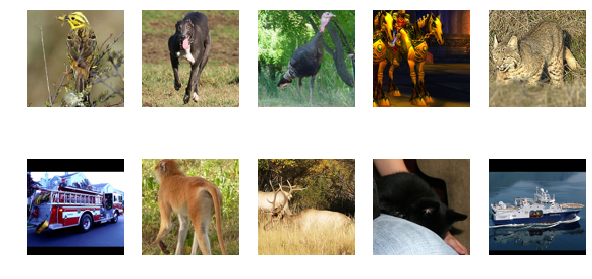

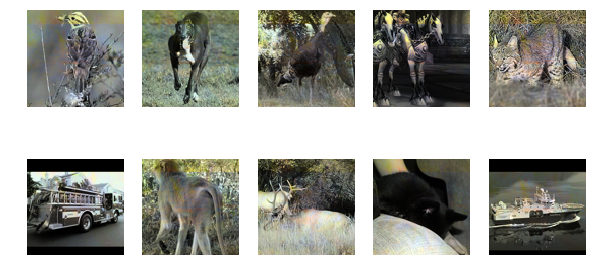

In [31]:
experiment_data   = train_images[np.random][:10]
experiment_data_t = tf.transpose(experiment_data,(1,2,0,3))
n = 1
with tf.device('/cpu:0'):
    s,U,V = tf.svd(experiment_data_t)
S         = tf.matrix_diag(s)

# smin      = tf.reduce_min(s,0,keepdims=True); smax      = tf.reduce_max(s,0,keepdims=True)
# ScaledS   = (mmax-mmin)*((s-smin)/(smax-smin)) + mmin

experiment_data_r  = U[:,:,:,:n] @ S[:,:,:n,:n] @ tf.transpose(V,(0,1,3,2))[:,:,:n,:]
experiment_data_r  = tf.transpose(experiment_data_r,(2,0,1,3))
experiment_data_r  = experiment_data_r.eval()
# layer9_3  = tf.transpose(layer9_2,(2,0,1,3)) 
# layer9_3  = layer9_3 * tf.transpose(ScaledS,(2,1,0))[:,:,:,None]
# return layer9_3

print(experiment_data.shape)
print(experiment_data_t.shape)
print(experiment_data_r.shape)
print(U.shape,S.shape,V.shape)

fig=plt.figure(figsize=(10, 5)) ; columns = 5 ; rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(experiment_data[i-1])
    plt.grid(False)
    plt.axis('off')
plt.show()

experiment_data_r = (experiment_data_r-experiment_data_r.min((1,2),keepdims=True))/( experiment_data_r.max((1,2),keepdims=True) - experiment_data_r.min((1,2),keepdims=True))
fig=plt.figure(figsize=(10, 5)) ; columns = 5 ; rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(experiment_data_r[i-1])
    plt.grid(False)
    plt.axis('off')
plt.show()